# Import Packages

In [1]:
# Importing necessary libraries
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

import traceback
from collections import OrderedDict
from tqdm.auto import tqdm

# Set the random seed for reproducibility
seed = 20230808
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set the device to GPU if available, otherwise use CPU
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

# Perform garbage collection and empty the GPU cache in PyTorch
gc.collect()
torch.cuda.empty_cache()


# Model

In [2]:
class NN(nn.Module):
    """
    A simple neural network class.

    Args:
        input_size (int): The number of input features.
        hidden_size (int): The number of hidden units in each hidden layer.
        output_size (int): The number of output features.
        depth (int): The number of hidden layers.
        ac (torch.nn.Module): The activation function to use for each hidden layer.
    """

    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        ac=torch.nn.Tanh,
    ):
        super(NN, self).__init__()

        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', ac()))
        for i in range(depth):
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, ac()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, input_size).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, output_size).
        """
        return self.layers(x)


# Training Loop

A one-dimensional wave equation is chosen for our experiments, which, in mathematical form, is defined as follows:

$$ u_{tt} - u_{xx} = 0$$

for this wave equation, its initial conditions and the homogeneous Dirichlet boundary conditions are given, as follows:

$$ u(0, x) = \frac{1}{2} \sin (\pi x)$$
$$ u_t(0, x) = \pi \sin (3 \pi x)$$
$$ u(t, 0) = 0 $$
$$ u(t, 0) = 0 $$

In [3]:
def init_weights(layer):
    """
    Initializes the weights of a layer with Xavier normal initialization.
    Args:
        layer (torch.nn.Module): The layer to initialize.
    """
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_normal_(layer.weight)


def ground_truth(x, t):
    return 1/2*torch.sin(math.pi*x)*torch.cos(math.pi*t) + 1/3*torch.sin(3*math.pi*x)*torch.sin(3*math.pi*t)


class Trainer:
    def __init__(self):
        # deep neural networks
        self.iter = 0
        self.model = NN(
            input_size=2,
            hidden_size=100,
            output_size=1,
            depth=5,
            ac=torch.nn.Tanh
        ).to(device)

        # use the Glorot normal initializer for initialization
        self.model.apply(init_weights)

        # General Loss Function
        self.criterion = torch.nn.MSELoss(reduction='mean')

        # Generate Training Data
        self.generate_data()
        self.best_loss = math.inf
        self.early_stop_count = 0
        self.__early_stop__ = 250

        # 2 kinds of optimizer
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )

        self.finetuner = torch.optim.Adam(self.model.parameters(),
                                          lr=8e-8,
                                          weight_decay=1e-8
                                          )

    def generate_data(self):
        # The initial conditions, boundary conditions
        # with Nu approximating 300
        self.h = 0.1
        self.k = 0.1
        x_u = torch.arange(0, 1 + self.h, self.h)
        t_u = torch.arange(0, 1 + self.k, self.k)
        c0 = torch.stack(torch.meshgrid(x_u, t_u[0])).reshape(2, -1).T
        c1 = torch.rand(300, 2)
        c2 = torch.stack(torch.meshgrid(x_u[0], t_u)).reshape(2, -1).T
        c3 = torch.stack(torch.meshgrid(x_u[-1], t_u)).reshape(2, -1).T

        y_c0 = 1/2*torch.sin(math.pi * c0[:, 0])
        y_c1 = ground_truth(x=c1[:, 0], t=c1[:, 1])
        y_c2 = torch.zeros(len(c2))
        y_c3 = torch.zeros(len(c3))

        self.X_u = torch.cat([c0, c1, c2, c3]).to(device)
        self.y_u = torch.cat([y_c0, y_c1, y_c2, y_c3]).unsqueeze(1).to(device)

        # Data in the space-time domain
        # with Nf approximating 40000
        self.h = 0.1
        self.k = 0.1
        x_f1 = torch.arange(0, 1 + self.h, self.h)
        t_f1 = torch.arange(0, 1 + self.k, self.k)
        X_f1 = torch.stack(torch.meshgrid(x_f1, t_f1)).reshape(2, -1).T
        X_f2 = torch.rand(40000, 2)
        self.X_f = torch.cat([X_f1, X_f2]).to(device)
        self.X_f.requires_grad = True
        print(
            f'Generating data with N_u:{self.X_u.shape[0]} N_f:{self.X_f.shape[0]}')

    def loss_func(self):
        self.optimizer.zero_grad()
        self.finetuner.zero_grad()

        # loss using observations of initial and boundary conditions
        loss_u = self.criterion(self.model(self.X_u), self.y_u)

        # loss based on partial differential equations
        u = self.model(self.X_f)
        u_X = torch.autograd.grad(
            u, self.X_f,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x, u_t = u_X[:, 0], u_X[:, 1]

        u_xx = torch.autograd.grad(
            u_x, self.X_f,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0][:, 0]

        u_tt = torch.autograd.grad(
            u_t, self.X_f,
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0][:, 1]

        loss_f = self.criterion(u_tt - u_xx, u_xx*0)
        loss = loss_u + loss_f
        loss.backward()
        if loss < self.best_loss:
            self.best_loss = loss.detach().item()
            torch.save(self.model.state_dict(), 'best_model.ckpt')
            self.early_stop_count = 0
        else:
            self.early_stop_count += 1

        if self.iter % 1000 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e with lowest loss %.5e' % (
                    self.iter, loss.detach().item(), loss_u.detach().item(), loss_f.detach().item(), self.best_loss)
            )
        self.iter = self.iter + 1
        return loss

    def train(self):
        self.model.train()
        self.optimizer.step(self.loss_func)
        while self.early_stop_count < self.__early_stop__:
            self.finetuner.step(self.loss_func)
        print('\nModel is not improving, so we halt the training session.')


# Training

In [8]:
Trainer().train()


Generating data with N_u:333 N_f:40121
Iter 0, Loss: 4.12520e-01, Loss_u: 4.11494e-01, Loss_f: 1.02595e-03 with lowest loss 4.12520e-01


KeyboardInterrupt: 

# Visualization

In [4]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import plotly.express as px

%matplotlib inline

plt.style.use(['ipynb', 'use_mathtext', 'colors5-light', 'science'])
sns.set_style('whitegrid')
sns.set_palette('RdBu')
sns.set(
    rc={'text.usetex': True},
    font='serif',
    font_scale=1.2
)


In [5]:
# Data
h, k = 0.005, 0.005
x, t = torch.arange(0, 1, h), torch.arange(0, 1, k)
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(device)

# Model
model = NN(input_size=2,
           hidden_size=100,
           output_size=1,
           depth=5,
           ac=torch.nn.Tanh).to(device)
model.load_state_dict(torch.load(
    'best_model.ckpt', map_location=torch.device('cpu') if not torch.cuda.is_available() else None))

# Evaluation
model.eval()
with torch.no_grad():
    y_true = ground_truth(X[:, 0], X[:, 1]).reshape(
        len(x), len(t)).detach().cpu().numpy()
    y_pred = model(X).reshape(len(x), len(t)).detach().cpu().numpy()


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1665731582897/work/aten/src/ATen/native/TensorShape.cpp:3217.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


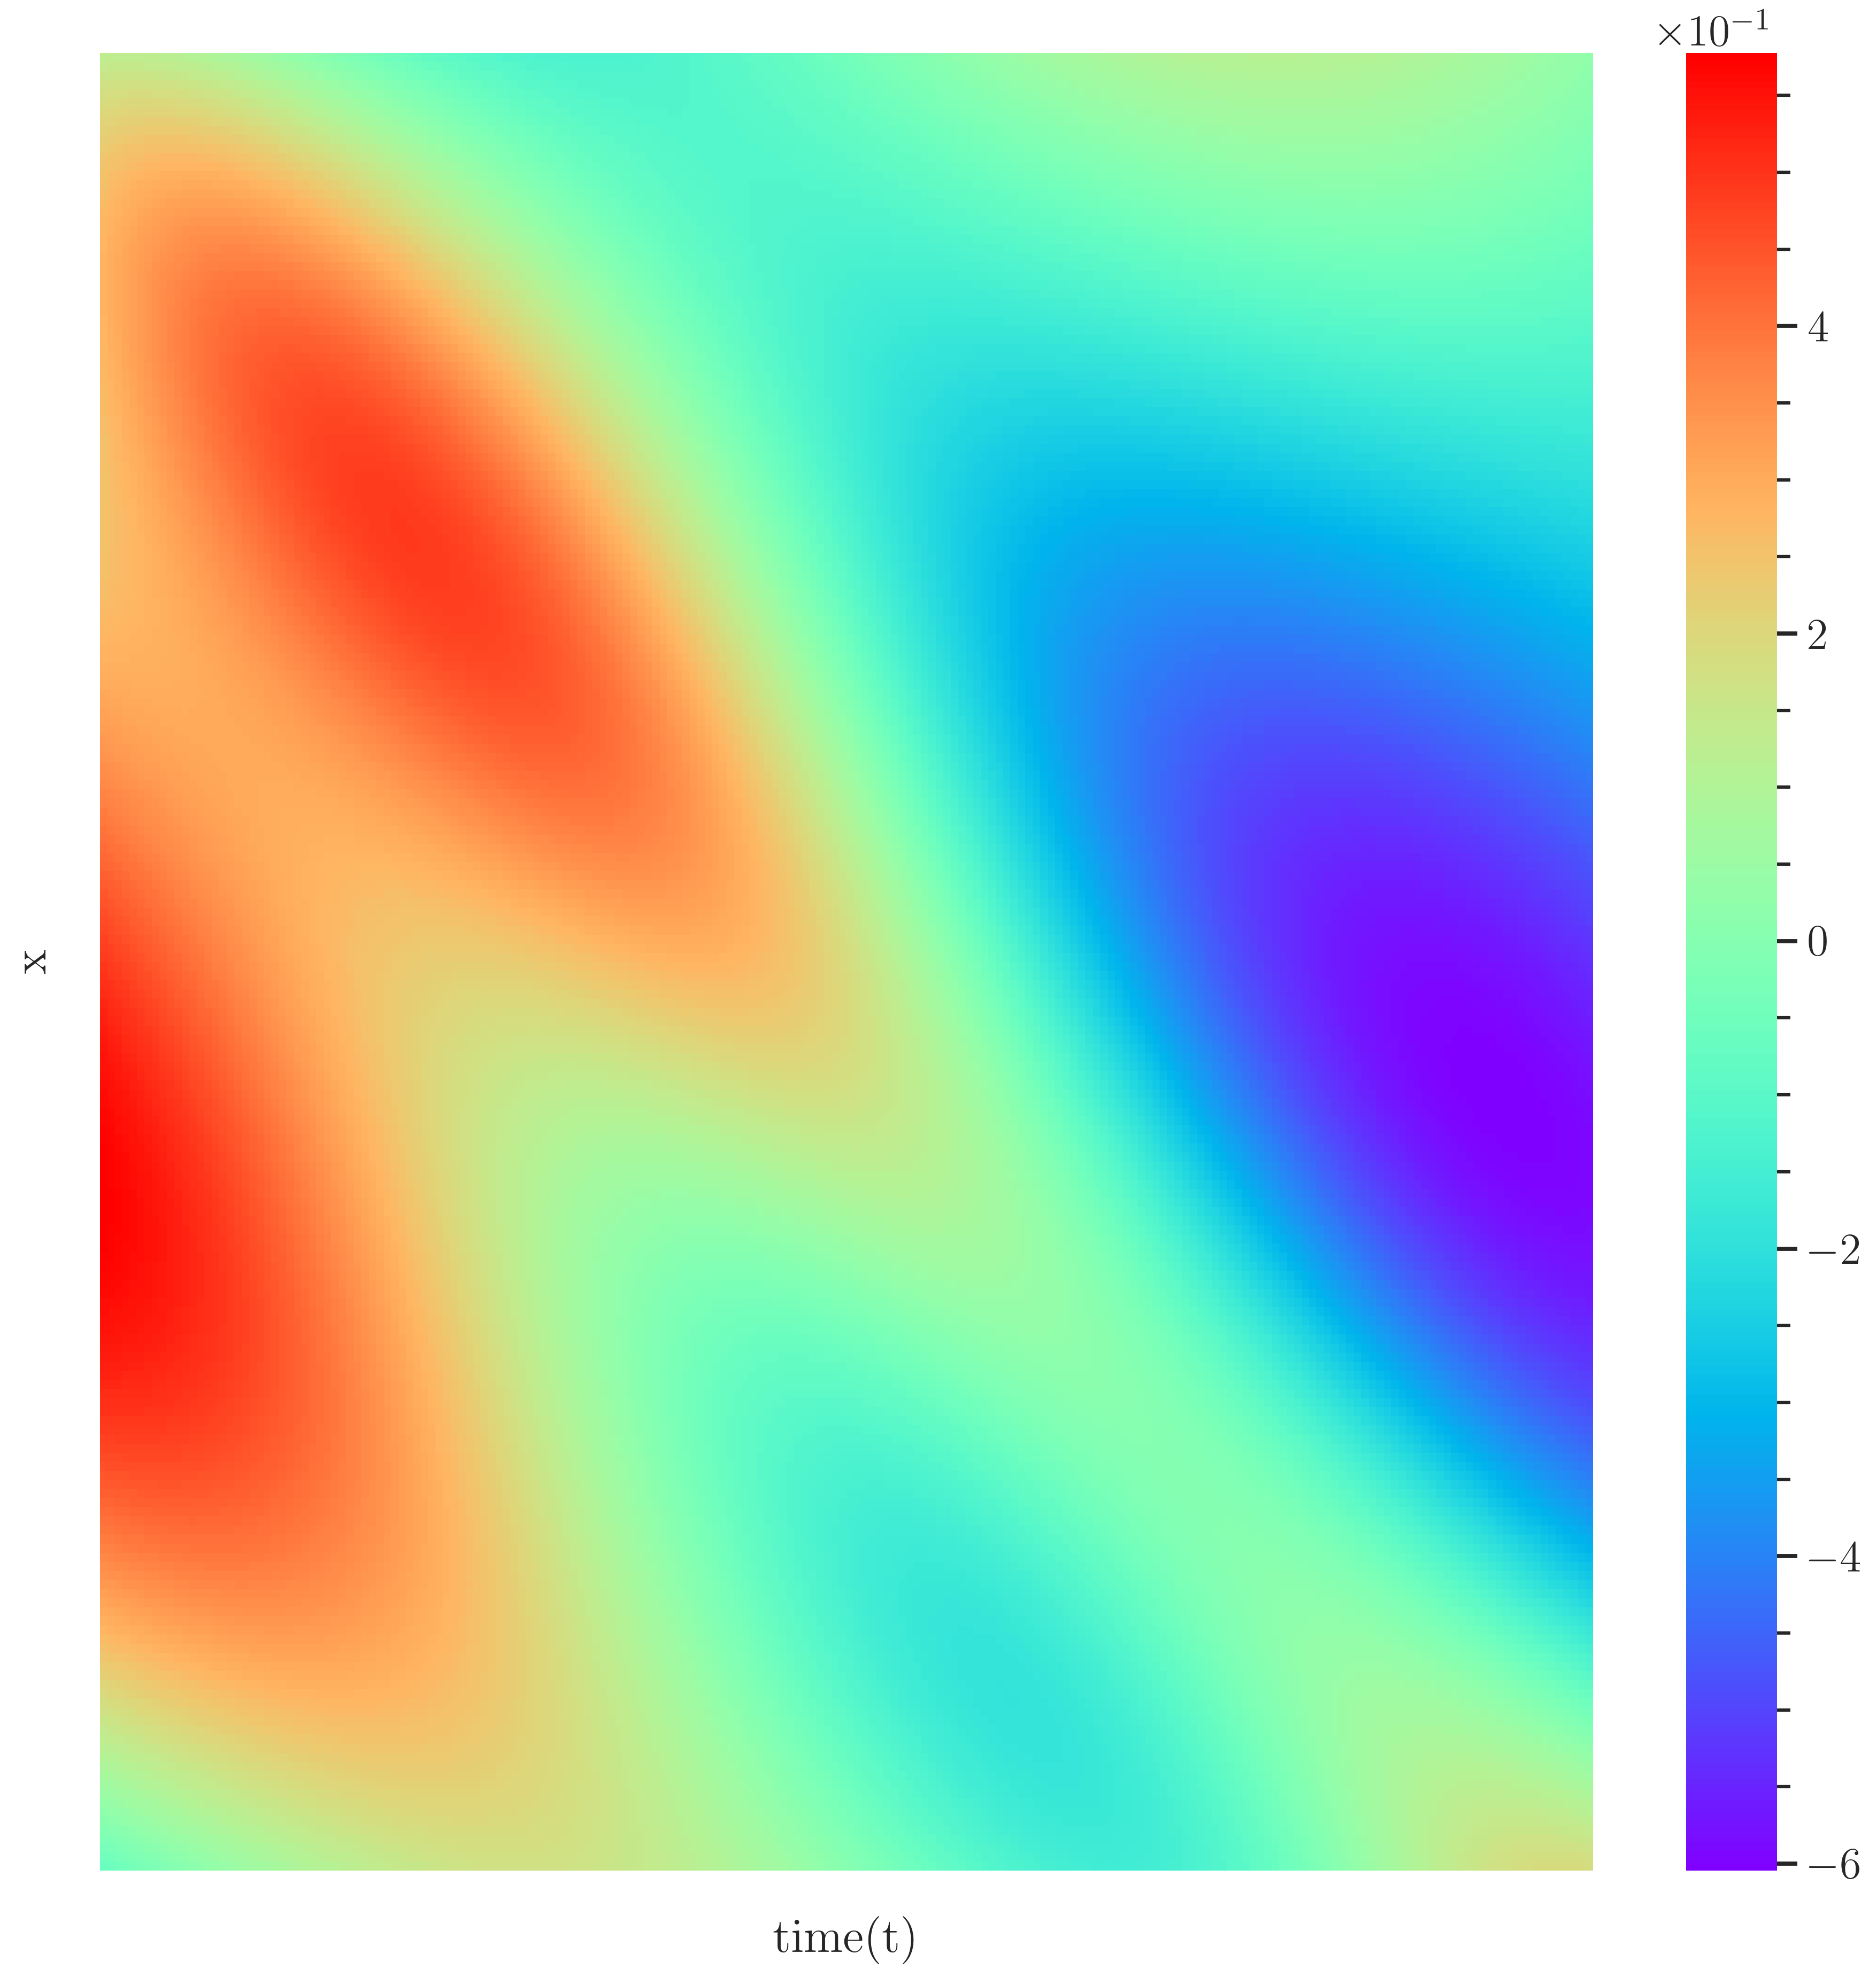

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
g = sns.heatmap(y_pred, cmap='rainbow', ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('time(t)')
ax.set_ylabel('x')
plt.show()


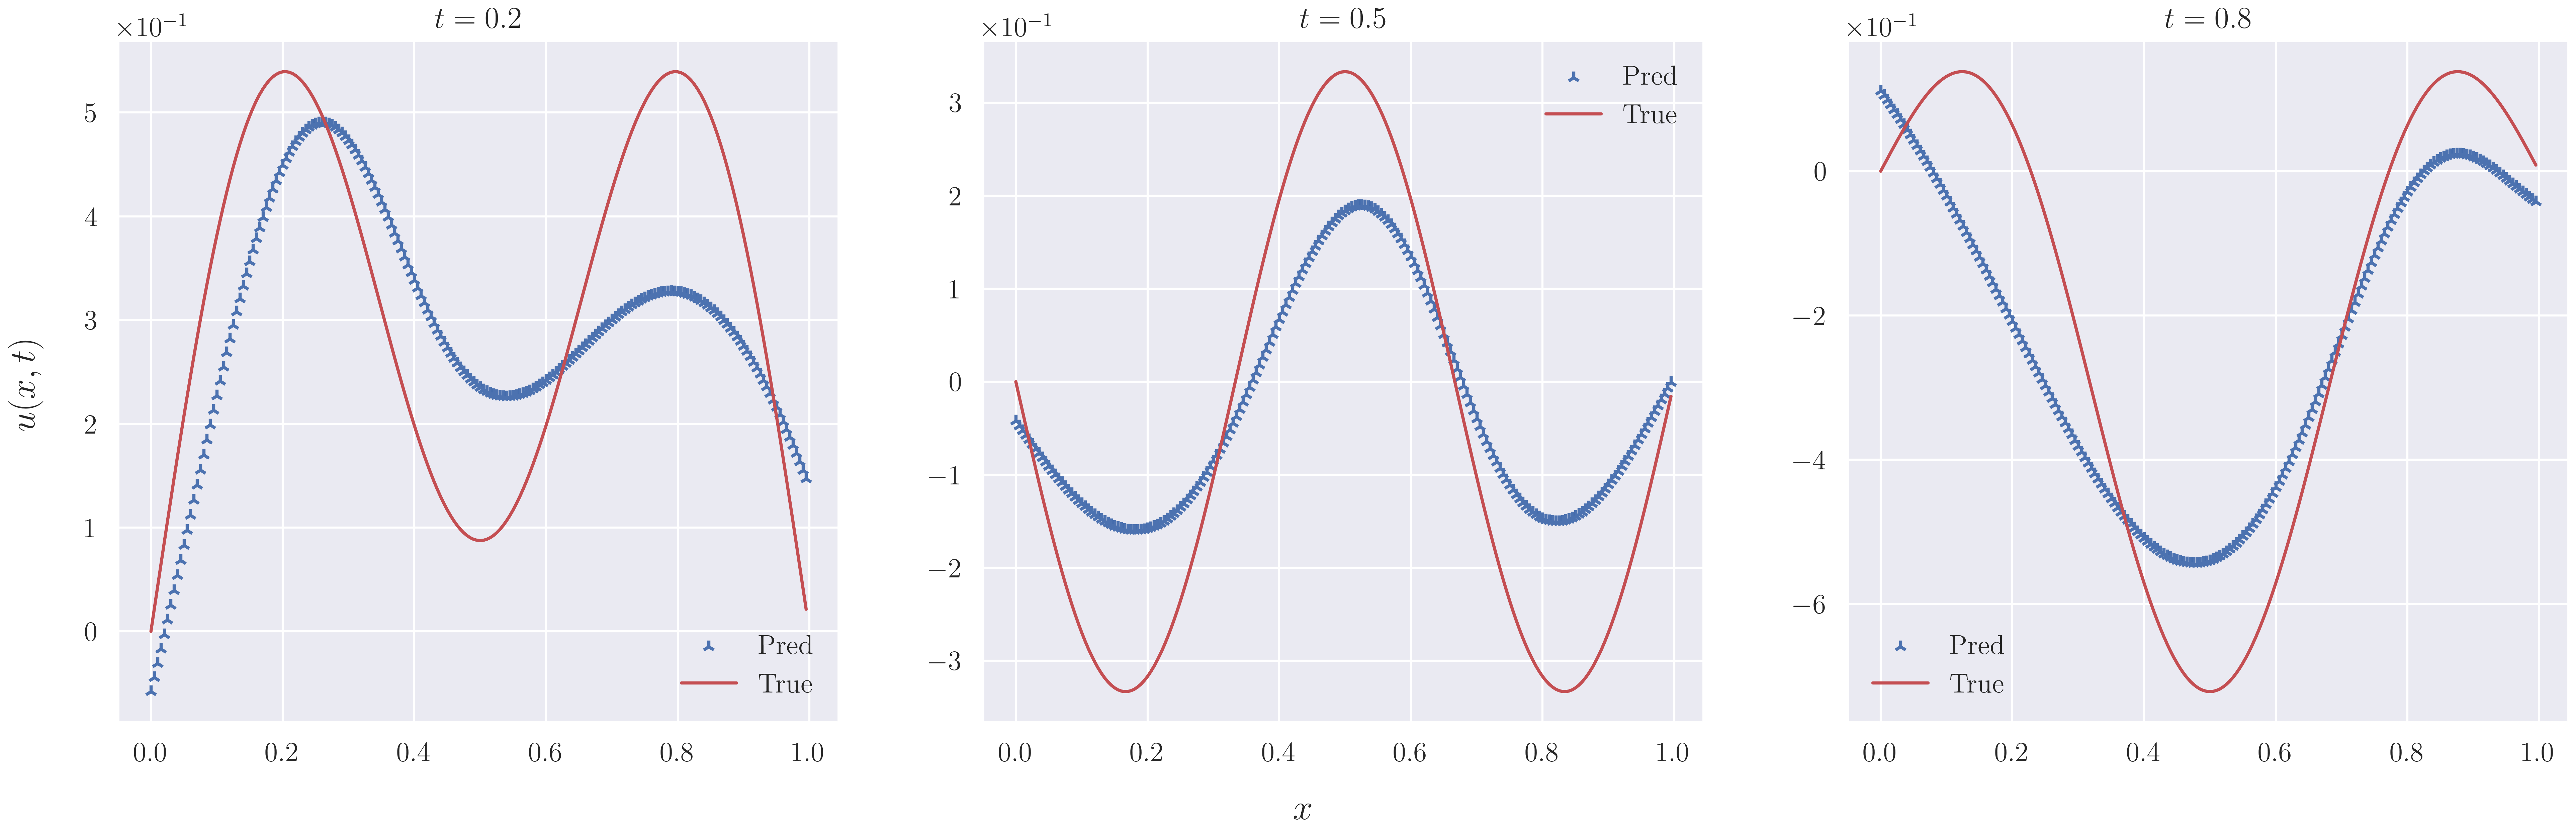

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for t, ax in zip([0.2, 0.5, 0.8], axes):
    xs = torch.arange(0, 1, h).unsqueeze(dim=1).to(device)
    ts = (torch.ones(x.shape)*t).to(device)
    ax.scatter(x.detach().cpu(),
               model(torch.cat([xs, ts], dim=1)).detach().cpu(),
               color='C0', marker='2', label='Pred')
    ax.plot(x.detach().cpu(),
            ground_truth(xs, ts).detach().cpu(),
            color='C3', marker='', label='True')
    ax.set_title(f'$t={t}$')
    ax.legend()

fig.supxlabel('$x$')
fig.supylabel('$u(x, t)$', x=0.09)
plt.show()
